# Deloitte data challenge part 2 

Pandas Basics: 


The dataset for this part of the interview can be found at
Link, You will see two .csv files which will form the basis of this part.  

Please use a Jupyter notebook and perform the following manipulations in order.  

1. Concat:
	- Vertically concatenate the two csvs into a new dataframe `df_full`; fill all missing values inside the test set with randomly selected values from the same column within the train set. 
2. Filter:
	- Create a new dataframe based on `df_full`. Select only the weekdays, where the relative humidity is >50 and abso <1.4 denote this new dataframe `df_filtered`. 

3. Apply:
	- on `df_filtered` create a new column `“sensor_combination”`. This column’s values should be equal to sensor 2 * sensor 3 if sensor 4 is less than the MEDIAN VALUE of sensor 4 for that calendar month. Otherwise it should be equal to (sensor 2 * sensor 4) minus the average sensor 4 value of that calendar month. 

4. Groupby:
	- On `df_full` table find the min/max/mean/count of temp over each day as a table denote as `df_group`. 

5. Create a column in `df_full`: 
	- Create a column `“sensor_one_binned”` that will contain information on which bin the sensor 1 value falls into. The bins are as follows 0-0.2, 0.2-0.5, 0.5-0.8, 0.8-0.85, 0.85-1. You can represent which bins each items falls into with an number, letter, or any other reasonable schema so long as you make a clear comment as to how it is stored. 
	- Create a column `“sensor_two_binned”` and fill it by performing the same operation on sensor 2. 
	- Display the number of values that fall into each bin for either sensor. 

6. Merge: Starting from `df_full` let’s look at the differences to the same day last year for available days 
	- How many days have data for both of the two latest years? 
	- What is the average of the daily differences of abs humidity between the latest and previous year? 
	- What is the difference between the averages of sensor 1 data for each year? 

7. Plots on `df_full`: 
	- Plot a histogram of absolute humidity. 
	- Plot sensor 1 - 5 histograms overlaid on same figure as each other (not the same figure as absolute humidity). 
	- Create a scatter plot of sensor 1 vs sensor 2 coloured blue if the data point is a weekday, red otherwise.
	- Plot a confusion matrix of predicted vs truth where you treat “sensor_one_binned” values as ground truth values and “sensor_two_binned” as predicted values. (Don’t worry that they are not actually ground truth and prediction values, we just want to see a nice plot)

8. Create a 70%/30% data split from the train.csv and ensure that observations from the same day are not split between sets. 

9. Save all resulting tables listed in ~~bold~~ monotype as CSVs. 


In [1]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
print([f for f in os.listdir('.') if not f.startswith('.')])

['Part Two Data', 'part_2.ipynb', 'df_filtered.csv', 'df_full.csv']


In [3]:
data_dir = Path('Part Two Data')
print("Files in dir:")
print([f.name for f in data_dir.iterdir()]) 

Files in dir:
['train.csv', 'test.csv']


### Let's look at the data first 

In [4]:
train_df = pd.read_csv(data_dir / "train.csv")
print(train_df.columns)
train_df 

Index(['date_time', 'deg_C', 'relative_humidity', 'absolute_humidity',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'],
      dtype='object')


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8
...,...,...,...,...,...,...,...,...,...,...,...,...
7106,2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,191.1
7107,2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,221.3
7108,2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,227.4
7109,2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,199.8


In [5]:
test_df = pd.read_csv(data_dir / "test.csv") 
test_df.columns 
test_df

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3
...,...,...,...,...,...,...,...,...,...
2242,2011-04-04 10:00:00,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8
2243,2011-04-04 11:00:00,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0
2244,2011-04-04 12:00:00,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1
2245,2011-04-04 13:00:00,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5


In [6]:
# And let's make the date_time column actually a datetime object.
# This will make it easier to filter by dates later.
train_df["date_time"] = pd.to_datetime(train_df["date_time"])
test_df["date_time"] = pd.to_datetime(test_df["date_time"])

In [7]:
print("Columns in train not in test:")
print([c for c in train_df.columns if c not in test_df.columns])

print("Columns in test not in train:")
print([c for c in test_df.columns if c not in train_df.columns])

# Check for existing null values 
assert not train_df.isna().any().any() and not test_df.isna().any().any() 

Columns in train not in test:
['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
Columns in test not in train:
[]


## 1: Make concatenated `df_full` 

In [8]:
df_full = pd.concat([train_df, test_df], axis=0, sort=False)

# Fill null values from test data with random value from train. 
# This will normally fill with the same index as param DataFrame, 
# so we make a shuffled train DF, and fill the null values of that 
# range only in the concatenated DF. 
shuffled_train_df = train_df.sample(frac=1).reset_index(drop=True) 
df_full.iloc[len(train_df):] = df_full.iloc[len(train_df):].fillna(shuffled_train_df)
df_full = df_full.reset_index(drop=True)

df_full

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8
...,...,...,...,...,...,...,...,...,...,...,...,...
9353,2011-04-04 10:00:00,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8,5.7,25.8,831.0
9354,2011-04-04 11:00:00,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0,3.1,17.2,324.7
9355,2011-04-04 12:00:00,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1,3.2,12.4,403.8
9356,2011-04-04 13:00:00,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5,0.9,4.9,108.0


## 2: Create `df_filtered` from `df_full` with only the weekdays and where the relative humidity is >50 and absolute humidity <1.4

In [9]:
df_filtered = df_full[df_full["date_time"].dt.weekday < 5]  # 0-4 is Monday-Friday
df_filtered = df_filtered[df_filtered["relative_humidity"] > 50]
df_filtered = df_filtered[df_filtered["absolute_humidity"] < 1.4]
df_filtered

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8
5,2010-03-10 23:00:00,11.2,56.8,0.7848,1220.9,697.5,1417.2,1462.6,949.0,1.2,4.4,88.1
6,2010-03-11 00:00:00,10.7,55.7,0.7603,1244.2,669.3,1491.2,1413.0,769.6,1.2,3.7,59.5
...,...,...,...,...,...,...,...,...,...,...,...,...
9346,2011-04-04 03:00:00,11.0,56.0,0.7888,878.1,538.5,1078.4,905.8,565.5,4.2,10.0,334.2
9347,2011-04-04 04:00:00,11.0,57.7,0.7743,907.2,458.9,1071.4,958.0,454.8,0.7,3.9,23.8
9348,2011-04-04 05:00:00,10.7,61.7,0.7550,941.3,549.1,1098.5,947.5,549.1,1.3,3.6,155.3
9349,2011-04-04 06:00:00,9.5,66.9,0.7531,989.8,686.2,805.6,1061.3,841.6,3.7,23.8,351.4


## 3. Create `sensor_combination` column in `df_filtered`. 

If sensor4 is less than sensor4 median for that calendar month, value = (sensor2 * sensor3). 

Else value = (sensor2 * sensor4) - (avg sensor4 value of that calendar month) 

In [10]:
# Create columns for the median and average of sensor4 for each month
df_tmp = df_filtered.copy()
dt_series = df_tmp["date_time"].dt
month_year_s4_groupby = df_tmp.groupby([dt_series.year, dt_series.month])["sensor_4"]
df_tmp["monthly_s4_median"] = month_year_s4_groupby.transform("median")
df_tmp["monthly_s4_mean"] = month_year_s4_groupby.transform("mean")

# Set default value for True condition (sensor4 < median)
df_filtered["sensor_combination"] = df_tmp["sensor_2"] * df_tmp["sensor_3"]
# Then use where() to set the False condition (sensor4 >= median)
df_filtered["sensor_combination"] = df_filtered["sensor_combination"].where(
    df_tmp["sensor_4"] < df_tmp["monthly_s4_median"],
    df_tmp["sensor_2"] * df_tmp["sensor_4"] - df_tmp["monthly_s4_mean"]
)

del df_tmp
df_filtered

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,sensor_combination
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,1.472880e+06
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,1.425850e+06
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,1.006953e+06
5,2010-03-10 23:00:00,11.2,56.8,0.7848,1220.9,697.5,1417.2,1462.6,949.0,1.2,4.4,88.1,9.884970e+05
6,2010-03-11 00:00:00,10.7,55.7,0.7603,1244.2,669.3,1491.2,1413.0,769.6,1.2,3.7,59.5,9.980602e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9346,2011-04-04 03:00:00,11.0,56.0,0.7888,878.1,538.5,1078.4,905.8,565.5,4.2,10.0,334.2,5.807184e+05
9347,2011-04-04 04:00:00,11.0,57.7,0.7743,907.2,458.9,1071.4,958.0,454.8,0.7,3.9,23.8,4.916655e+05
9348,2011-04-04 05:00:00,10.7,61.7,0.7550,941.3,549.1,1098.5,947.5,549.1,1.3,3.6,155.3,6.031863e+05
9349,2011-04-04 06:00:00,9.5,66.9,0.7531,989.8,686.2,805.6,1061.3,841.6,3.7,23.8,351.4,7.272214e+05


## 4. On `df_full` table find the min/max/mean/count of temp over each day as a table denote as `df_group`.

In [11]:
df_group = df_full.groupby(df_full["date_time"].dt.date)["deg_C"].agg(["min", "max", "mean", "count"])
df_group

,min,max,mean,count
date_time,,,,
2010-03-10,11.0,13.2,12.166667,6
2010-03-11,7.7,11.4,9.762500,24
2010-03-12,5.7,16.2,11.133333,24
2010-03-13,6.2,19.0,12.779167,24
2010-03-14,10.0,22.7,15.800000,24
...,...,...,...,...
2011-03-31,12.0,23.9,17.583333,24
2011-04-01,12.6,20.4,15.737500,24
2011-04-02,10.6,22.6,15.458333,24


## 5. Binning values in `df_full`

1. Create column `sensor_one_binned` which is the bin of sensor 1 data
2. Create column `sensor_two_binned` which is the bin of sensor 2 data
3. Count number of values in each bin

I'm interpreting the values `[0, 0.2, 0.5, 0.8, 0.85, 1]` as the fraction of the range of sensor values for
since all the values are much larger than 1.
This means there are different bin ranges for each sensor value.

I use integers for bin labels, label $\ell \in [0, 4]$

In [12]:
# frac of range for each bin
bin_fracs = [0, 0.2, 0.5, 0.8, 0.85, 1]
# Adjust for floating point errors:
# pd.cut() causes a NaN at the minimum value (even with include_lowest=True)...
eps_adj = 1e-12

def bin_sensor(series) -> pd.Series:
    """Bin a sensor series according to the bin_fracs list."""
    min_val = series.min() - eps_adj
    max_val = series.max() + eps_adj
    range_val = max_val - min_val
    bin_tuples = [(min_val + range_val * frac, min_val + range_val * bin_fracs[i + 1])
                  for i, frac in enumerate(bin_fracs[:-1])]
    bins = pd.IntervalIndex.from_tuples(bin_tuples)
    return pd.cut(series, bins=bins, include_lowest=True).apply(
        lambda x: bin_tuples.index((x.left, x.right))
    )

# Create bins for sensor 1 and 2
df_full["sensor_one_binned"] = bin_sensor(df_full["sensor_1"])
df_full["sensor_two_binned"] = bin_sensor(df_full["sensor_2"])

print(df_full["sensor_one_binned"].value_counts())
print()
print(df_full["sensor_two_binned"].value_counts())

assert df_full["sensor_one_binned"].isna().sum() == 0
assert df_full["sensor_two_binned"].isna().sum() == 0

sensor_one_binned
1    6216
0    1944
2    1148
3      34
4      16
Name: count, dtype: int64

sensor_two_binned
1    5782
0    2826
2     743
3       4
4       3
Name: count, dtype: int64


## 6. In `df_full`, look at data on same day from previous year

In [13]:
# 6.1: Get days that have data in both years.
# First filter by those years
latest_year = df_full["date_time"].max().year
prev_year = latest_year - 1

df_tmp = df_full.copy()
df_tmp["year"] = df_tmp["date_time"].dt.year
df_tmp["month"] = df_tmp["date_time"].dt.month
df_tmp["day"] = df_tmp["date_time"].dt.day

latest_year_days = df_tmp[df_tmp["date_time"].dt.year == latest_year]
prev_year_days = df_tmp[df_tmp["date_time"].dt.year == prev_year]
# Then merge these on the month and day and group
both_years_df = latest_year_days.merge(prev_year_days, how="inner", on=[
    "month", "day"
]).groupby(["month", "day"])
# Then just count the number of days in both years
num_days_in_both = len(both_years_df.count())
print(num_days_in_both)

26


In [14]:
# 6.2: Get average of daily differences in absolute humidity between years

daily_humidity_increases = (both_years_df.absolute_humidity_y.mean() - both_years_df.absolute_humidity_x.mean())
print("Daily humidity increases:")
print(daily_humidity_increases)
print()
print("Mean daily humidity increases:")
print(daily_humidity_increases.mean())

Daily humidity increases:
month  day
3      10     0.221796
       11     0.212183
       12    -0.101488
       13    -0.074825
       14     0.027637
       15     0.164112
       16     0.144258
       17     0.065404
       18     0.080254
       19    -0.014279
       20    -0.020963
       21     0.000675
       22    -0.088158
       23    -0.068021
       24    -0.154842
       25    -0.450279
       26    -0.549729
       27    -0.628592
       28    -0.522183
       29    -0.556183
       30    -0.402467
       31    -0.110125
4      1      0.138575
       2      0.388721
       3      0.343121
       4      0.316701
dtype: float64

Mean daily humidity increases:
-0.06302673076923077


In [15]:
# 6.3: Get difference of yearly averages of sensor 1 data

# First get averages for each year
s1_yearly_means = df_full.groupby(df_full["date_time"].dt.year)["sensor_1"].mean()
# then get the difference
s1_yearly_diff = s1_yearly_means.diff()
print(s1_yearly_diff)
print()
print("Only two years in dataset, so only one difference:", s1_yearly_diff.iloc[-1])

date_time
2010          NaN
2011    14.965822
Name: sensor_1, dtype: float64

Only two years in dataset, so only one difference: 14.965821708685326


## 7. Plots on `df_full`

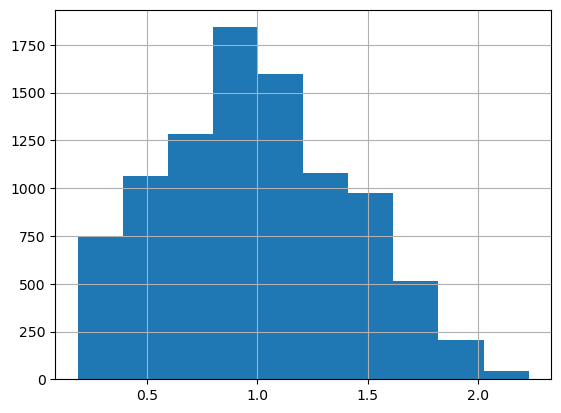

In [16]:
# 7.1: Plot histogram of absolute humidity
with plt.ioff():
    fig = df_full["absolute_humidity"].hist()
    plt.show()

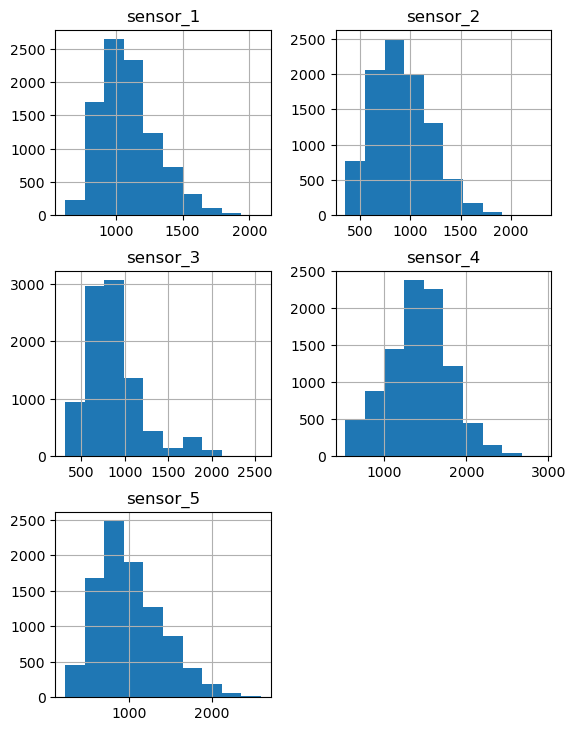

In [17]:
# 7.2: Plot sensor 1-5 histograms overlaid on same plot

with plt.ioff():
    fig = df_full[["sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5"]].hist()
    plt.subplots_adjust(top=1.5)  # so the labels don't overlap
    plt.show()


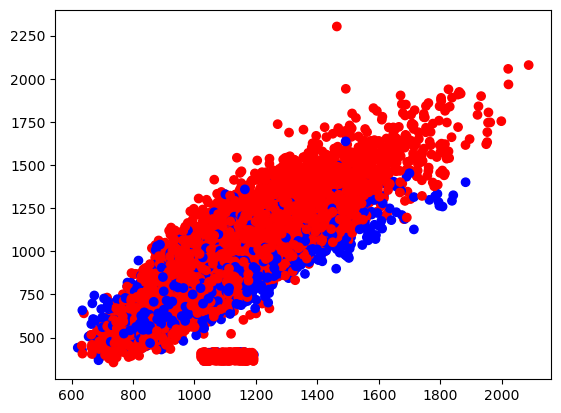

In [18]:
# 7.3: Scatter plot of sensor 1 vs sensor 2, blue if weekday red if weekend
colors = pd.Series(['blue'] * len(df_full)).where(
    df_full["date_time"].dt.weekday >= 5, other='red'
)
with plt.ioff():
    fig = plt.scatter(df_full["sensor_1"], df_full["sensor_2"], c=colors)
    plt.show()

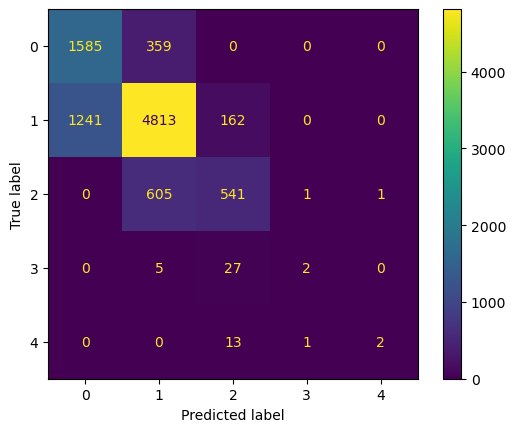

In [19]:
# 7.4: Confusion matrix of sensor_1_binned vs sensor_2_binned

label = df_full["sensor_one_binned"]
pred = df_full["sensor_two_binned"]
conf_mat = confusion_matrix(label, pred)
with plt.ioff():
    fig = ConfusionMatrixDisplay(conf_mat).plot()
    plt.show()


## 8. Create a 70%/30% data split from train.csv

- ensure that observations from the same day are not split between sets.
- This potentially makes getting the proper split harder if dates not roughly uniformly distributed.
Let's look at the distribution of days first to determine how to split.


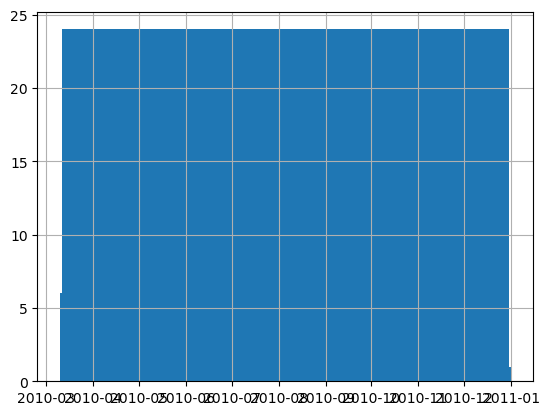

In [20]:
split_train = train_df.copy()
split_train["date"] = split_train["date_time"].dt.date
with plt.ioff():
    fig = split_train.date.hist(bins=len(split_train["date"].unique()))
    plt.show()


Oh good! Nearly every day has 24 observations, so we don't need to do any complicated splitting procedure.
We can just split on the date, and maybe make adjustments after.

In [21]:
# 8.1: Split on date

# Get the date of the 70% mark
split_date = split_train["date"].unique()[int(len(split_train["date"].unique()) * 0.7)]
# Split the data
train = split_train[split_train["date"] <= split_date]
validation = split_train[split_train["date"] > split_date]

print("Train shape:", train.shape)
print("Test shape:", validation.shape)
print("Num overlapping dates:",
      len(set(train["date"].unique()).intersection(set(validation["date"].unique()))))
print("Fraction of data in train:", len(train) / (len(train) + len(validation)))

Train shape: (4998, 13)
Test shape: (2113, 13)
Num overlapping dates: 0
Fraction of data in train: 0.7028547321051891


## 9. Save `df_full` and `df_filtered` to csv

In [22]:
df_full.to_csv("df_full.csv")
df_filtered.to_csv("df_filtered.csv")